# Customer Churn Analysis 


## Section 1: Data Preparation

We used several Pandas functions to load and review the dataset, focusing on data quality and the meaning of each feature.  
After checking the DataFrame shape, we found a total of **7,043 observations and 21 features**.

Except for `customerID`, the remaining 20 features were categorized into three groups:
- **Customer demographics**
- **Product/Service-related features**
- **Payment history**

Since Python is a case-sensitive language, to ensure consistency and ease of analysis in later steps, we converted all column names and string values to **lowercase**.

Upon reviewing the data types, we noticed that the `totalcharges` column was incorrectly stored as an object instead of a numeric type. This column was converted to numeric for proper analysis.

After cross-checking features like `phoneservice` and `internetservice`, `multipleline` we identified three customer groups:
- **Phone service only**
- **Internet service only**
- **Multiple services**

We created a new feature to label each observation accordingly.

Several features such as `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, and `streamingmovies` are only relevant for customers with **internet service**. Customers using only phone service naturally have missing values in these fields.


In [57]:
# import lib
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, recall_score, precision_score
from sklearn.inspection import permutation_importance

import joblib

In [ ]:
# Load the dataset
data_path = (
    "/customer_churn_predict/data/telco_churn_rate.csv"
)
df = pd.read_csv(data_path)
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
df.shape

(7043, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Nomalize string in dataset:

df.columns = df.columns.str.lower().str.replace(" ", "_")
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
# totalcharge column is string, we need to convert it to float
df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors="coerce")

df["multiplelines"] = df["multiplelines"].replace("no_phone_service", "no")
condition_list = [
    (df["phoneservice"] == "yes") & (df["multiplelines"] == "no"),
    (df["internetservice"].isin(["fiber_optic", "dsl"]))
    & (df["multiplelines"] == "no"),
    df["multiplelines"] == "yes",
]
choice_list = ["phone service only", "internet service only", "multiplelines"]

df["service_line"] = np.select(condition_list, choice_list, default="Unknown")

In [6]:
df.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## Section 2: Exploratory Data Analysis (EDA)

### 2.1 Target Variable

The target variable in this dataset is `churn`, where:
- `'yes'` = customer has churned  
- `'no'` = customer has not churned

We examined the class distribution to assess imbalance. The churn rate is **26.5%**, while the non-churn rate is **73.5%**.  
This level of churn is relatively typical in service industries.

However, since our goal is to build a machine learning model to **predict churn**, it's essential to consider **resampling techniques** such as **oversampling** or **undersampling** to ensure the model can learn from the minority class (churn).

We also analyzed the churn distribution across different service lines to check for any unique patterns. The churn rates across services were similar to the overall dataset, so no need to split the data by service type at this point.


In [7]:
# Set Varibles needed:
phone_only = df["service_line"] == "phone service only"
internet_only = df["service_line"] == "internet service only"
both_service = df["service_line"] == "multiplelines"

churn = df["churn"] == "yes"
not_churn = df["churn"] == "no"

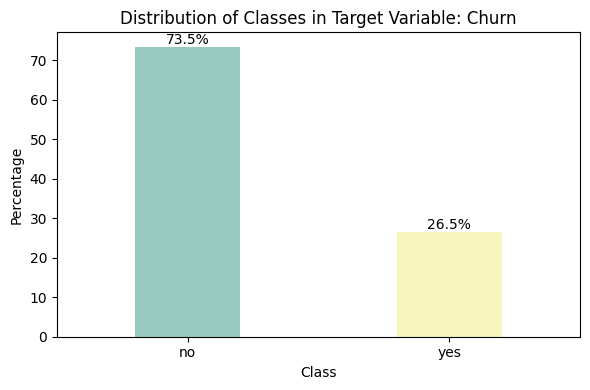

In [8]:
f, ax = plt.subplots(figsize=(6, 4))
plot = sns.countplot(
    x="churn", data=df, palette="Set3", hue="churn", legend=False, stat="percent"
)
bar_width = 0.4
for bar in plot.patches:
    current_width = bar.get_width()
    diff = current_width - bar_width
    bar.set_width(bar_width)
    bar.set_x(bar.get_x() + diff * 0.5)
    percentage = f"{bar.get_height():.1f}%"
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        percentage,
        ha="center",
        va="bottom",
    )

plt.title("Distribution of Classes in Target Variable: Churn")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

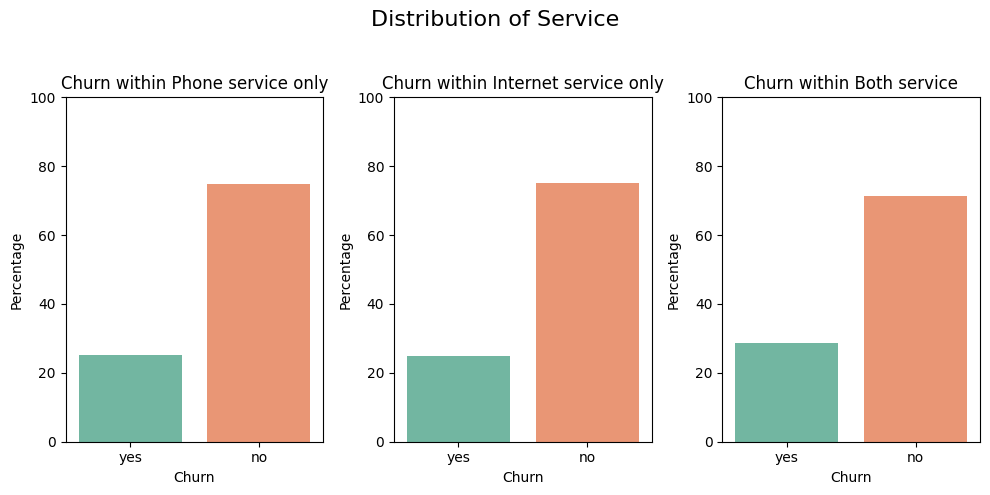

In [9]:
f, ax = plt.subplots(1, 3, figsize=(10, 5))

sns.countplot(
    df[phone_only],
    x="churn",
    ax=ax[0],
    palette="Set2",
    hue="churn",
    hue_order=["yes", "no"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[0].set_title("Churn within Phone service only")
ax[0].set_xlabel("Churn")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim([0, 100])

sns.countplot(
    df[internet_only],
    x="churn",
    ax=ax[1],
    palette="Set2",
    hue="churn",
    hue_order=["yes", "no"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[1].set_title("Churn within Internet service only")
ax[1].set_xlabel("Churn")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim([0, 100])

sns.countplot(
    df[both_service],
    x="churn",
    ax=ax[2],
    palette="Set2",
    hue="churn",
    hue_order=["yes", "no"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[2].set_title("Churn within Both service")
ax[2].set_xlabel("Churn")
ax[2].set_ylabel("Percentage")
ax[2].set_ylim([0, 100])

f.suptitle("Distribution of Service", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2.2 Demographic Features

This group includes: `gender`, `seniorcitizen`, `partner`, and `dependents`.

Key findings from visualizations:
- The **gender distribution** in both churn and non-churn groups is balanced (roughly 50/50).
- Around **80%** of customers are younger (i.e., `seniorcitizen = 0`).  
  However, among churned customers, the elderly (`seniorcitizen = 1`) make up a higher proportion (**~20%+**) compared to non-churned customers (**~10%+**).
- Customers **without partners** (`partner = no`) are more likely to churn (~60%), while among non-churners, the ratio is more balanced. A similar trend is observed for the `dependents` feature.


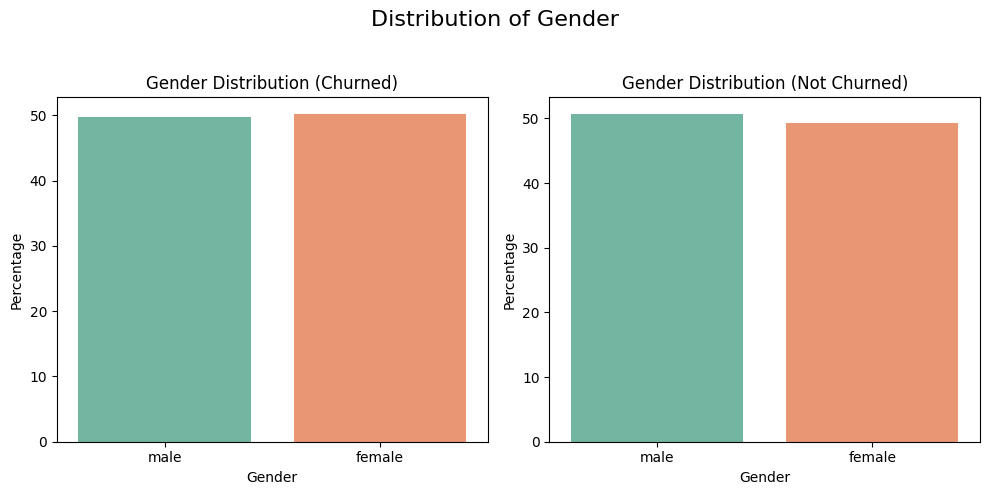

In [10]:
# distribution of genders

f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="gender",
    ax=ax[0],
    palette="Set2",
    hue="gender",
    hue_order=["male", "female"],
    legend=False,
    stat="percent",
    order=["male", "female"],
)
ax[0].set_title("Gender Distribution (Churned)")
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("Percentage")

sns.countplot(
    df[not_churn],
    x="gender",
    ax=ax[1],
    palette="Set2",
    hue="gender",
    hue_order=["male", "female"],
    legend=False,
    stat="percent",
    order=["male", "female"],
)
ax[1].set_title("Gender Distribution (Not Churned)")
ax[1].set_xlabel("Gender")
ax[1].set_ylabel("Percentage")

f.suptitle("Distribution of Gender", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

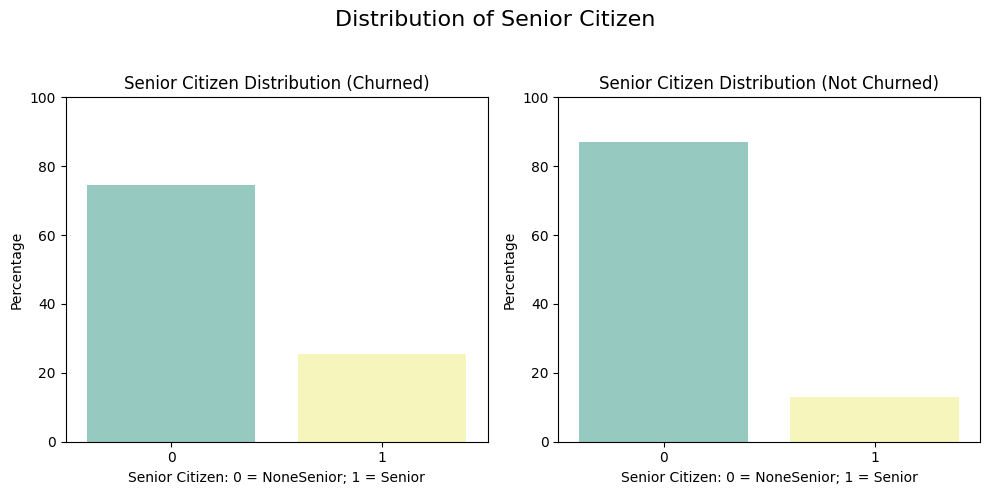

In [11]:
# seniorcitizen
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="seniorcitizen",
    ax=ax[0],
    palette="Set3",
    hue="seniorcitizen",
    hue_order=[0, 1],
    legend=False,
    stat="percent",
    order=[0, 1],
)
ax[0].set_title("Senior Citizen Distribution (Churned)")
ax[0].set_xlabel("Senior Citizen: 0 = NoneSenior; 1 = Senior")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="seniorcitizen",
    ax=ax[1],
    palette="Set3",
    hue="seniorcitizen",
    hue_order=[0, 1],
    legend=False,
    stat="percent",
    order=[0, 1],
)
ax[1].set_title("Senior Citizen Distribution (Not Churned)")
ax[1].set_xlabel("Senior Citizen: 0 = NoneSenior; 1 = Senior")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Senior Citizen", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

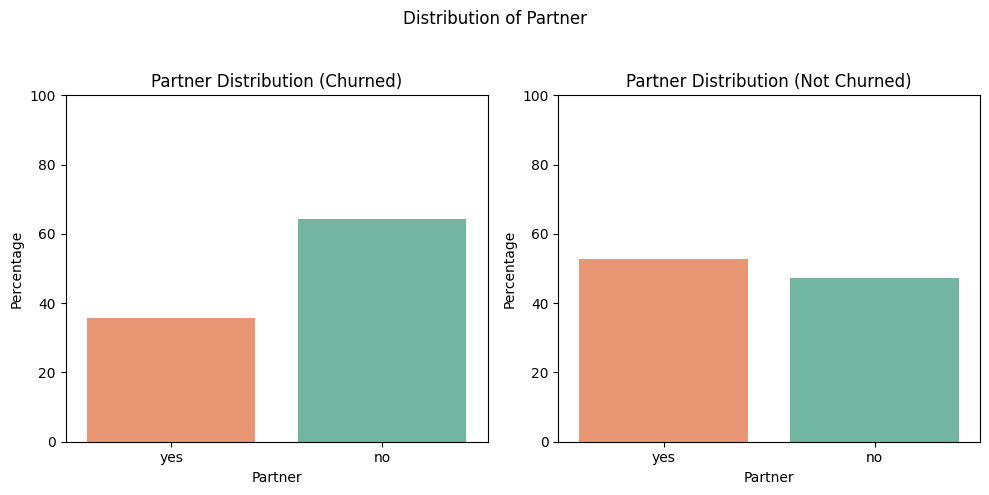

In [12]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="partner",
    ax=ax[0],
    palette="Set2",
    hue="partner",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[0].set_title("Partner Distribution (Churned)")
ax[0].set_xlabel("Partner")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="partner",
    ax=ax[1],
    palette="Set2",
    hue="partner",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[1].set_title("Partner Distribution (Not Churned)")
ax[1].set_xlabel("Partner")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Partner")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

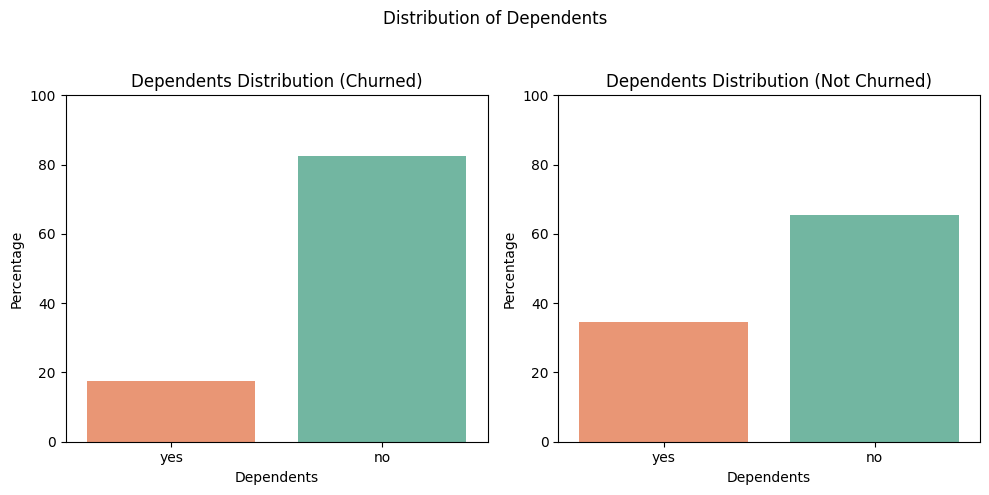

In [13]:
# dependents
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="dependents",
    ax=ax[0],
    palette="Set2",
    hue="dependents",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[0].set_title("Dependents Distribution (Churned)")
ax[0].set_xlabel("Dependents")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="dependents",
    ax=ax[1],
    palette="Set2",
    hue="dependents",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["yes", "no"],
)
ax[1].set_title("Dependents Distribution (Not Churned)")
ax[1].set_xlabel("Dependents")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Dependents")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2.3 Product/Service Features

As noted earlier, features like `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, and `streamingmovies` are only applicable for customers with internet service.

Usage patterns:
- Features like `onlinesecurity`, `onlinebackup`, `deviceprotection`, and `techsupport` have **relatively low usage rates**.
- In contrast, **streaming services** (`streamingtv`, `streamingmovies`) are **more widely adopted**.

Customers who:
- Use **month-to-month contracts**
- Pay via **electronic checks**
- Enable **paperless billing**

...tend to have **higher churn rates** than those using longer-term contracts or other payment methods.



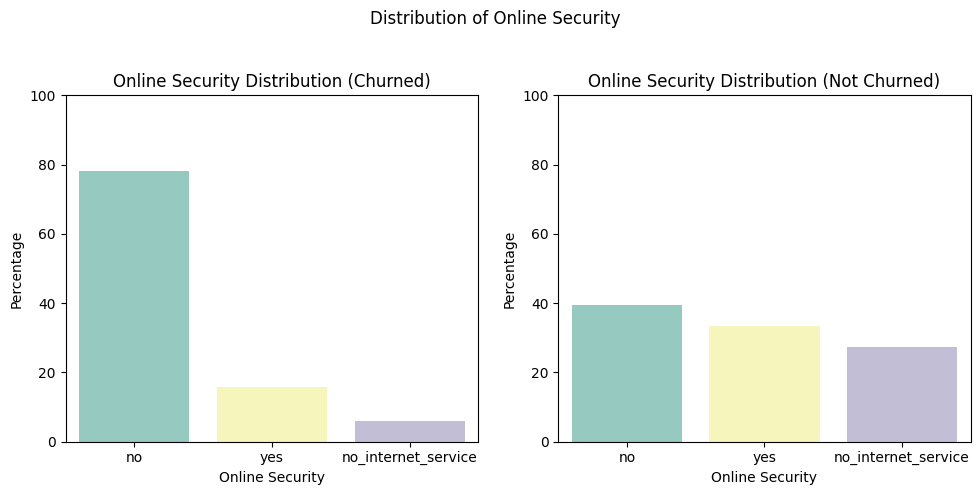

In [14]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="onlinesecurity",
    ax=ax[0],
    palette="Set3",
    hue="onlinesecurity",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[0].set_title("Online Security Distribution (Churned)")
ax[0].set_xlabel("Online Security")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="onlinesecurity",
    ax=ax[1],
    palette="Set3",
    hue="onlinesecurity",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[1].set_title("Online Security Distribution (Not Churned)")
ax[1].set_xlabel("Online Security")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Online Security")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

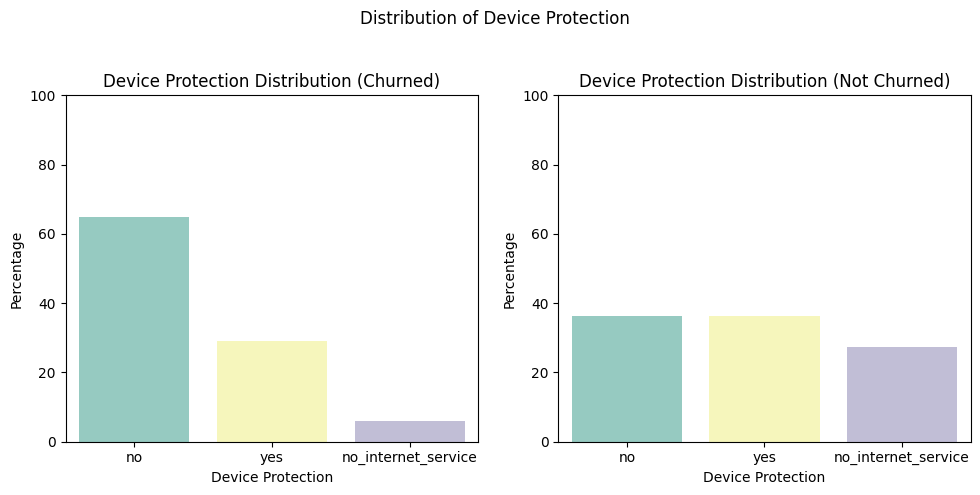

In [15]:
# devicprotection
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="deviceprotection",
    ax=ax[0],
    palette="Set3",
    hue="deviceprotection",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[0].set_title("Device Protection Distribution (Churned)")
ax[0].set_xlabel("Device Protection")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="deviceprotection",
    ax=ax[1],
    palette="Set3",
    hue="deviceprotection",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[1].set_title("Device Protection Distribution (Not Churned)")
ax[1].set_xlabel("Device Protection")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Device Protection")
plt.tight_layout(rect=[0, 0, 1, 0.95])

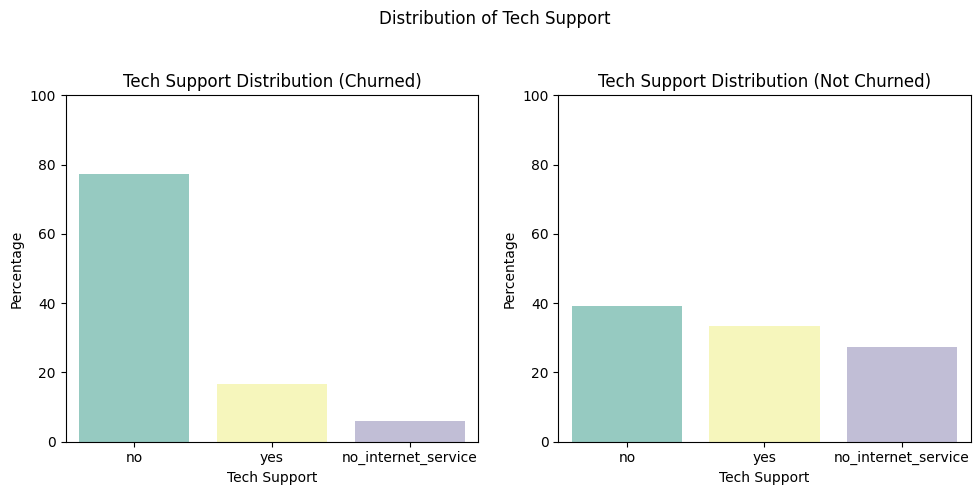

In [16]:
# techsupport
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="techsupport",
    ax=ax[0],
    palette="Set3",
    hue="techsupport",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[0].set_title("Tech Support Distribution (Churned)")
ax[0].set_xlabel("Tech Support")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="techsupport",
    ax=ax[1],
    palette="Set3",
    hue="techsupport",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[1].set_title("Tech Support Distribution (Not Churned)")
ax[1].set_xlabel("Tech Support")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Tech Support")
plt.tight_layout(rect=[0, 0, 1, 0.95])

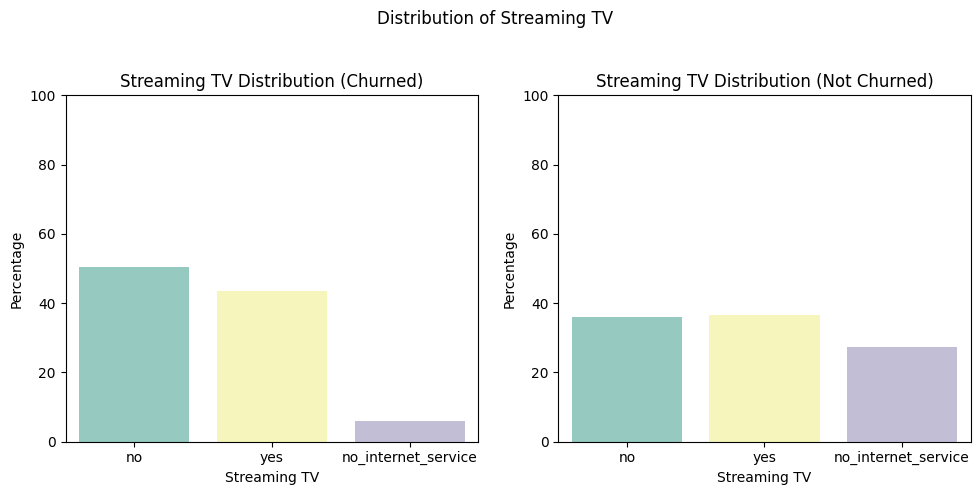

In [17]:
# streamingtv
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="streamingtv",
    ax=ax[0],
    palette="Set3",
    hue="streamingtv",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[0].set_title("Streaming TV Distribution (Churned)")
ax[0].set_xlabel("Streaming TV")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="streamingtv",
    ax=ax[1],
    palette="Set3",
    hue="streamingtv",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[1].set_title("Streaming TV Distribution (Not Churned)")
ax[1].set_xlabel("Streaming TV")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Streaming TV")
plt.tight_layout(rect=[0, 0, 1, 0.95])

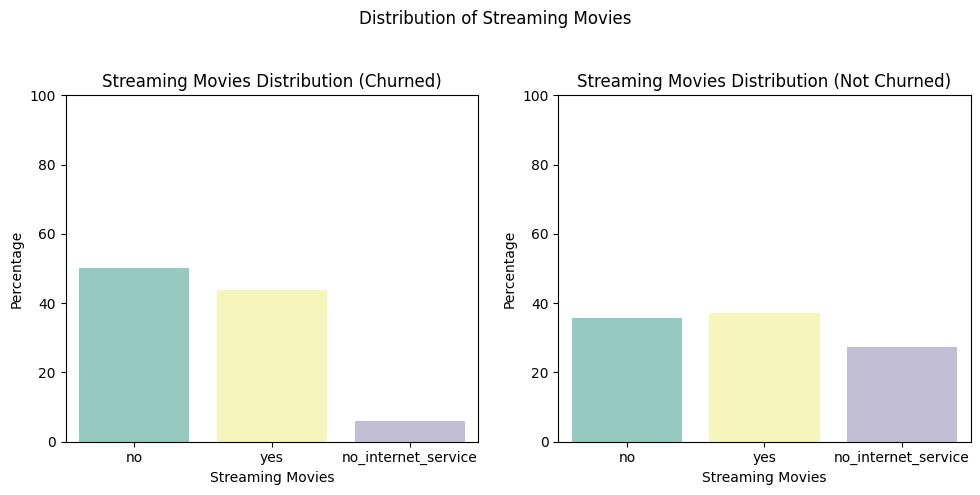

In [18]:
# streamingmovies
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="streamingmovies",
    ax=ax[0],
    palette="Set3",
    hue="streamingmovies",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[0].set_title("Streaming Movies Distribution (Churned)")
ax[0].set_xlabel("Streaming Movies")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="streamingmovies",
    ax=ax[1],
    palette="Set3",
    hue="streamingmovies",
    hue_order=["no", "yes", "no_internet_service"],
    legend=False,
    stat="percent",
    order=["no", "yes", "no_internet_service"],
)
ax[1].set_title("Streaming Movies Distribution (Not Churned)")
ax[1].set_xlabel("Streaming Movies")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Streaming Movies")
plt.tight_layout(rect=[0, 0, 1, 0.95])

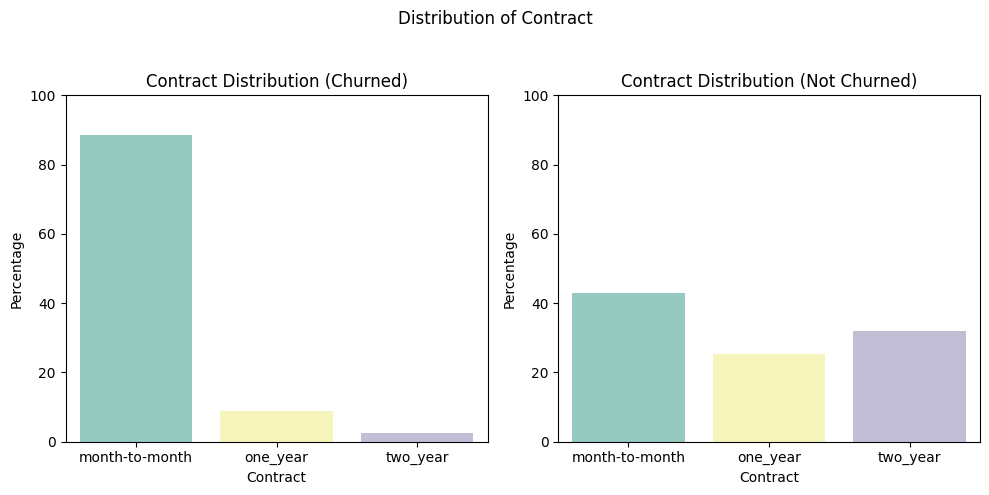

In [19]:
# contract

f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="contract",
    ax=ax[0],
    palette="Set3",
    hue="contract",
    hue_order=["month-to-month", "one_year", "two_year"],
    legend=False,
    stat="percent",
    order=["month-to-month", "one_year", "two_year"],
)
ax[0].set_title("Contract Distribution (Churned)")
ax[0].set_xlabel("Contract")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="contract",
    ax=ax[1],
    palette="Set3",
    hue="contract",
    hue_order=["month-to-month", "one_year", "two_year"],
    legend=False,
    stat="percent",
    order=["month-to-month", "one_year", "two_year"],
)
ax[1].set_title("Contract Distribution (Not Churned)")
ax[1].set_xlabel("Contract")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Contract")
plt.tight_layout(rect=[0, 0, 1, 0.95])

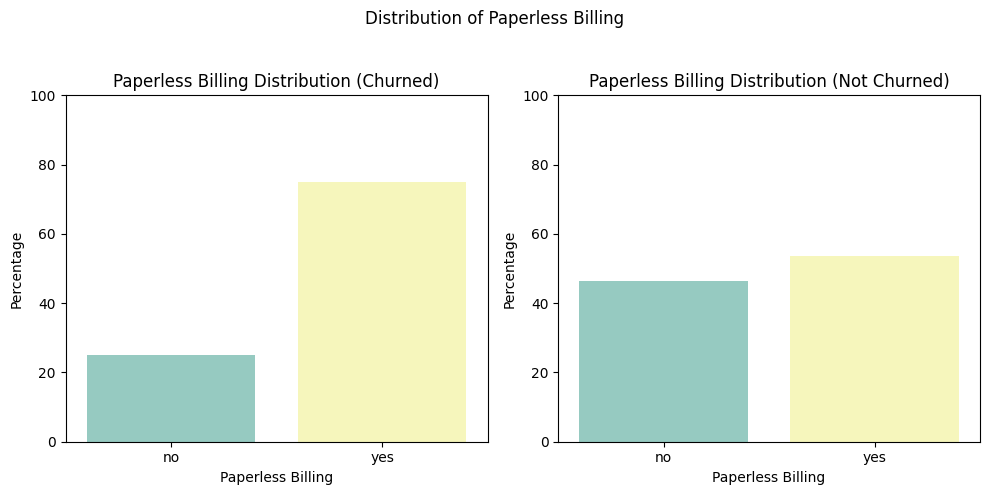

In [20]:
# paperlessbilling

f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="paperlessbilling",
    ax=ax[0],
    palette="Set3",
    hue="paperlessbilling",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["no", "yes"],
)
ax[0].set_title("Paperless Billing Distribution (Churned)")
ax[0].set_xlabel("Paperless Billing")
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="paperlessbilling",
    ax=ax[1],
    palette="Set3",
    hue="paperlessbilling",
    hue_order=["no", "yes"],
    legend=False,
    stat="percent",
    order=["no", "yes"],
)
ax[1].set_title("Paperless Billing Distribution (Not Churned)")
ax[1].set_xlabel("Paperless Billing")
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Paperless Billing")
plt.tight_layout(rect=[0, 0, 1, 0.95])

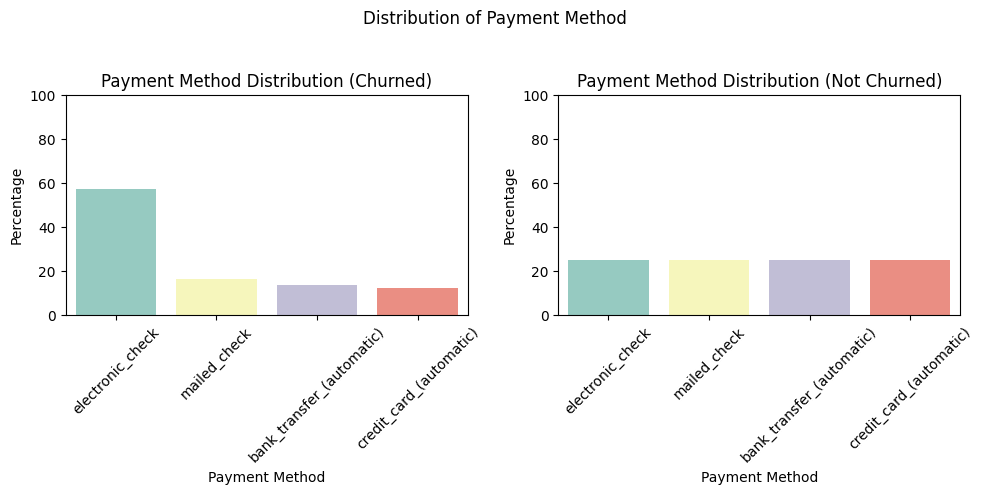

In [21]:
# paymentmethod
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    df[churn],
    x="paymentmethod",
    ax=ax[0],
    palette="Set3",
    hue="paymentmethod",
    hue_order=[
        "electronic_check",
        "mailed_check",
        "bank_transfer_(automatic)",
        "credit_card_(automatic)",
    ],
    legend=False,
    stat="percent",
    order=[
        "electronic_check",
        "mailed_check",
        "bank_transfer_(automatic)",
        "credit_card_(automatic)",
    ],
)
ax[0].set_title("Payment Method Distribution (Churned)")
ax[0].set_xlabel("Payment Method")
ax[0].tick_params(axis="x", rotation=45)
ax[0].set_ylabel("Percentage")
ax[0].set_ylim(0, 100)

sns.countplot(
    df[not_churn],
    x="paymentmethod",
    ax=ax[1],
    palette="Set3",
    hue="paymentmethod",
    hue_order=[
        "electronic_check",
        "mailed_check",
        "bank_transfer_(automatic)",
        "credit_card_(automatic)",
    ],
    legend=False,
    stat="percent",
    order=[
        "electronic_check",
        "mailed_check",
        "bank_transfer_(automatic)",
        "credit_card_(automatic)",
    ],
)
ax[1].set_title("Payment Method Distribution (Not Churned)")
ax[1].set_xlabel("Payment Method")
ax[1].tick_params(axis="x", rotation=45)
ax[1].set_ylabel("Percentage")
ax[1].set_ylim(0, 100)

f.suptitle("Distribution of Payment Method")
plt.tight_layout(rect=[0, 0, 1, 0.95])

### 2.4 Payment History Features

This group includes: `tenure`, `monthlycharges`, and `totalcharges`.

Upon investigation, we found **614 out of 7,043 records** where `totalcharges` equals the product of `tenure` and `monthlycharges`.  
Most of these belong to **month-to-month** contract customers.

Some records with `one-year` or `two-year` contracts also fall into this group but have a `tenure` of only 1 month, possibly indicating new customers still in their **trial phase**.

We observed a **strong correlation** between `totalcharges`, `tenure`, and `monthlycharges`.  
To avoid **multicollinearity**, we may consider **dropping `totalcharges`** from the training set and keeping:
- `tenure` → reflects customer loyalty  
- `monthlycharges` → represents financial commitment

#### Monthly Charges:
- **Phone service users** have a wider range of monthly fees than internet users.  
  Among churners, there’s a **right-skewed distribution**, meaning those who left the service tended to pay **higher monthly charges**.
- Customers using **both phone and internet services** also show higher average charges, especially in the churn group.  
  A few low-charge outliers are present among churners in this group.

#### Tenure (in months):
- **Churned customers** generally have **shorter tenure**, as seen from the left-skewed distribution.
- **Longer tenures** are more common among current customers, especially those using **multiple services**, suggesting that satisfied users are more likely to stay longer and subscribe to bundled services.


In [22]:
df_total_charges = df[df["totalcharges"] == df["tenure"] * df["monthlycharges"]]
df_total_charges["contract"].value_counts()

contract
month-to-month    605
one_year            7
two_year            2
Name: count, dtype: int64

In [23]:
df_total_charges[df_total_charges["contract"] != "month-to-month"]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,service_line
222,6469-mrvet,male,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,one_year,yes,electronic_check,20.20,20.20,no,phone service only
1168,5562-betpv,male,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,one_year,no,mailed_check,19.65,19.65,no,phone service only
1286,8985-oopos,female,0,no,no,1,yes,no,dsl,no,...,yes,yes,yes,one_year,no,credit_card_(automatic),74.10,74.10,no,phone service only
1654,2967-mxrav,male,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,one_year,no,mailed_check,18.80,18.80,no,phone service only
2828,8559-wnqzs,male,0,no,no,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,20.45,20.45,no,phone service only
2993,2239-cfouj,male,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,one_year,no,mailed_check,20.40,20.40,no,phone service only
4767,1064-fbxnk,male,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,one_year,no,credit_card_(automatic),19.85,19.85,no,phone service only
5987,1099-godlo,female,0,yes,yes,1,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,20.35,20.35,no,phone service only
6149,3069-ssvsn,female,0,no,no,1,no,no,dsl,no,...,no,no,no,one_year,no,mailed_check,25.85,25.85,no,internet service only


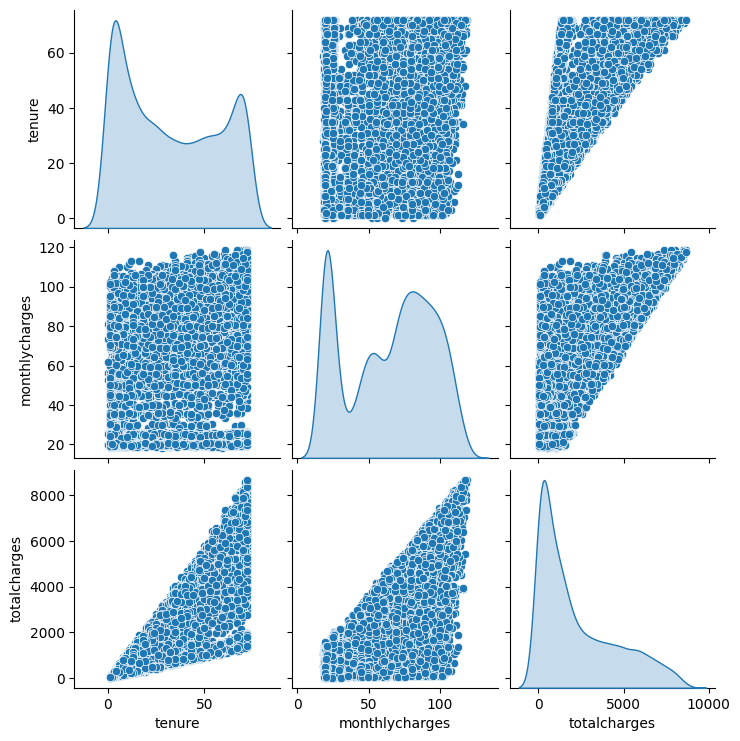

In [24]:
df_num_rel = df[["tenure", "monthlycharges", "totalcharges"]]
sns.pairplot(df_num_rel, diag_kind="kde")

Text(0.5, 0.98, 'Monthly charges distribution by Services')

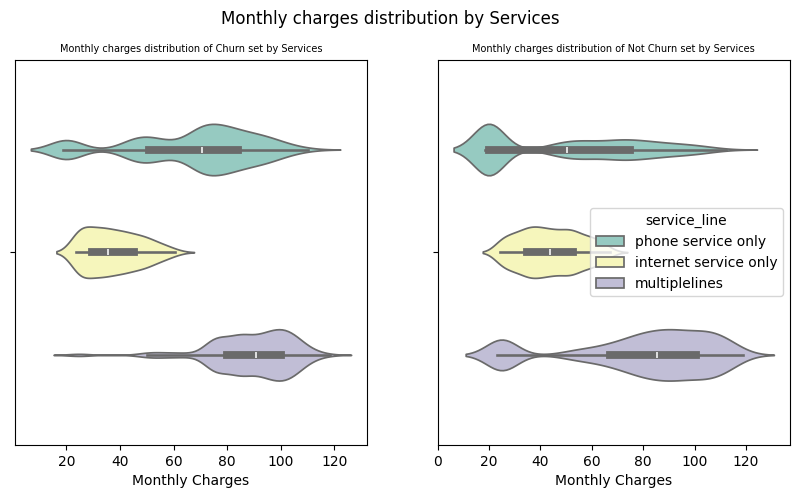

In [25]:
# Monthly Charges
f, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(
    df[churn],
    x="monthlycharges",
    ax=ax[0],
    hue="service_line",
    hue_order=["phone service only", "internet service only", "multiplelines"],
    palette="Set3",
    gap=0.5,
    legend=False,
)
ax[0].set_title("Monthly charges distribution of Churn set by Services", fontsize=7)
ax[0].set_xlabel("Monthly Charges")

sns.violinplot(
    df[not_churn],
    x="monthlycharges",
    ax=ax[1],
    hue="service_line",
    hue_order=["phone service only", "internet service only", "multiplelines"],
    palette="Set3",
    gap=0.5,
)
sns.move_legend(ax[1], "center right")

ax[1].set_title("Monthly charges distribution of Not Churn set by Services", fontsize=7)
ax[1].set_xlabel("Monthly Charges")

f.suptitle("Monthly charges distribution by Services")

Text(0.5, 0.98, 'Tenure distribution by Services')

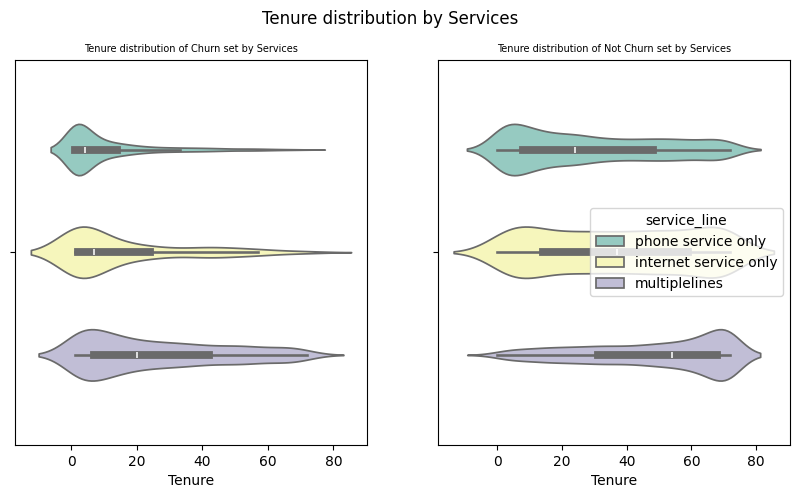

In [26]:
# Monthly Charges
f, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(
    df[churn],
    x="tenure",
    ax=ax[0],
    hue="service_line",
    hue_order=["phone service only", "internet service only", "multiplelines"],
    palette="Set3",
    gap=0.5,
    legend=False,
)
ax[0].set_title("Tenure distribution of Churn set by Services", fontsize=7)
ax[0].set_xlabel("Tenure")

sns.violinplot(
    df[not_churn],
    x="tenure",
    ax=ax[1],
    hue="service_line",
    hue_order=["phone service only", "internet service only", "multiplelines"],
    palette="Set3",
    gap=0.5,
)
sns.move_legend(ax[1], "center right")

ax[1].set_title("Tenure distribution of Not Churn set by Services", fontsize=7)
ax[1].set_xlabel("Tenure")

f.suptitle("Tenure distribution by Services")

## Section 3: Feature Engineering and Sampling 

In [27]:
# Make a copy of data

df_ml = df.copy()
df_ml.drop(
    columns=[
        "totalcharges",
        "customerid",
        "phoneservice",
        "internetservice",
        "multiplelines",
    ],
    inplace=True,
    axis=1,
)

binary_map = {"yes": "1", "no": "0", "male": "1", "female": "0"}
for col in ["gender", "partner", "dependents", "churn"]:
    df_ml[col] = df_ml[col].map(binary_map)
    df_ml[col] = df_ml[col].astype(int)

In [28]:
# prepare features for engineering
numerical_cols = ["tenure", "monthlycharges"]
categorical_cols = df_ml.select_dtypes(include="object").columns.tolist()
binary_cols = ["gender", "partner", "dependents"]

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [29]:
# Split Train, Validation, Test with ratio 60:20:20
X_transformed = preprocessor.fit_transform(df_ml.drop(columns="churn"))
y_transformed = df_ml["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_transformed, test_size=0.2, random_state=42
)

## 4. Model Implementation <br>

Define a function to calculate and visualize evaluation metrics:

In [30]:
def evaluate_classification_model(
    model, X_train, y_train, X_test, y_test, model_name="Model"
):
    """
    Evaluate classification performance with classification report, confusion matrix, and PR-AUC.
    Works for any classifier that supports predict and predict_proba or decision_function.
    """

    # --- Predictions ---
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- Classification Reports ---
    print(f"\n1.a: {model_name} - Classification Report (Train Set):")
    print(classification_report(y_train, y_train_pred))

    print(f"\n2.a: {model_name} - Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # --- Confusion Matrices ---
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    ConfusionMatrixDisplay(
        confusion_matrix=cm_train, display_labels=["No Churn (0)", "Churn (1)"]
    ).plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix (Train Set)")
    plt.show()

    ConfusionMatrixDisplay(
        confusion_matrix=cm_test, display_labels=["No Churn (0)", "Churn (1)"]
    ).plot(cmap=plt.cm.Reds)
    plt.title(f"{model_name} - Confusion Matrix (Test Set)")
    plt.show()

    # --- Probability Scores ---
    def get_scores(m, X):
        return m.predict(X)

    y_train_scores = get_scores(model, X_train)
    y_test_scores = get_scores(model, X_test)

    # --- Precision-Recall & AUC ---
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)

    ap_train = average_precision_score(y_train, y_train_scores)
    ap_test = average_precision_score(y_test, y_test_scores)

    print(f"\n3.a: {model_name} - PR-AUC (Train Set): {ap_train:.4f}")
    print(f"3.b: {model_name} - PR-AUC (Test Set): {ap_test:.4f}")

    # --- PR Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(
        recall_train,
        precision_train,
        label=f"Train PR Curve (AP={ap_train:.4f})",
        color="red",
    )
    plt.plot(
        recall_test,
        precision_test,
        label=f"Test PR Curve (AP={ap_test:.4f})",
        color="blue",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

### 4.1 Logistic Model

#### a. Initial model

In [31]:
# make a pipeline with logistic
log_model = LogisticRegression(class_weight="balanced", max_iter=1000)
log_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### b. Model Evaluation


1.a: Logistic Regression - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      4138
           1       0.51      0.79      0.62      1496

    accuracy                           0.74      5634
   macro avg       0.71      0.76      0.71      5634
weighted avg       0.80      0.74      0.76      5634


2.a: Logistic Regression - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1036
           1       0.53      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



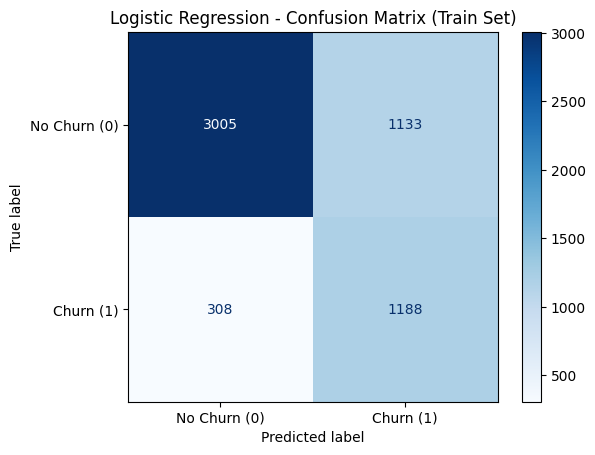

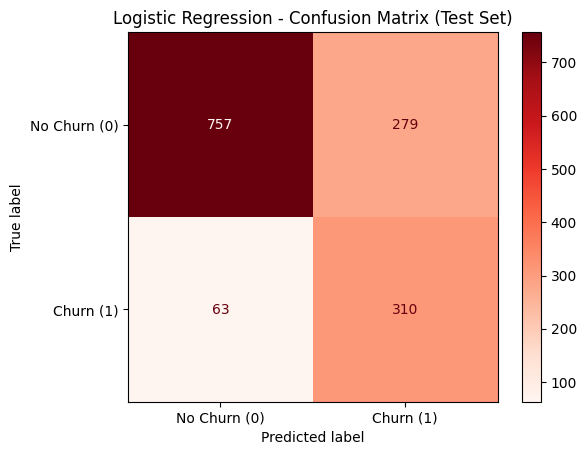


3.a: Logistic Regression - PR-AUC (Train Set): 0.4611
3.b: Logistic Regression - PR-AUC (Test Set): 0.4821


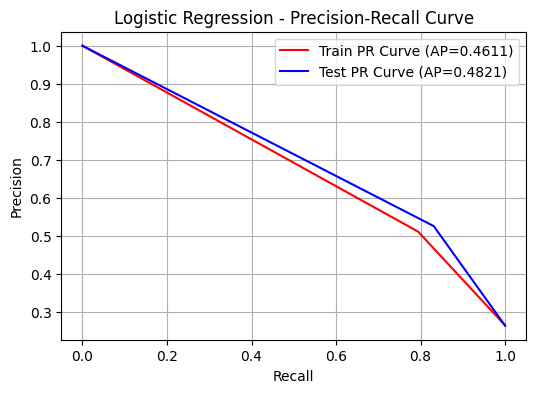

In [32]:
# Evaluate the logistic regression model on Train and Validation sets
log_model_eval = evaluate_classification_model(
    log_model, X_train, y_train, X_test, y_test, model_name="Logistic Regression"
)

#### c. Tunning Model

In [33]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"],
}

grid = GridSearchCV(log_model, param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


#### d. Refit Model with Best Param

In [34]:
best_log_model = grid.best_estimator_


1.a: Optimized Logistic Regression - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      4138
           1       0.51      0.79      0.62      1496

    accuracy                           0.74      5634
   macro avg       0.71      0.76      0.71      5634
weighted avg       0.80      0.74      0.76      5634


2.a: Optimized Logistic Regression - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1036
           1       0.53      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



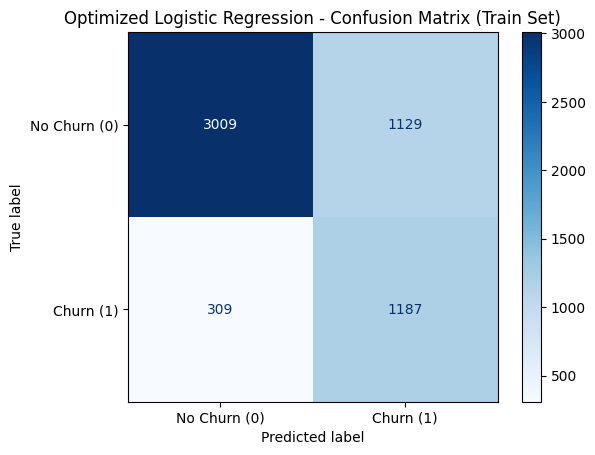

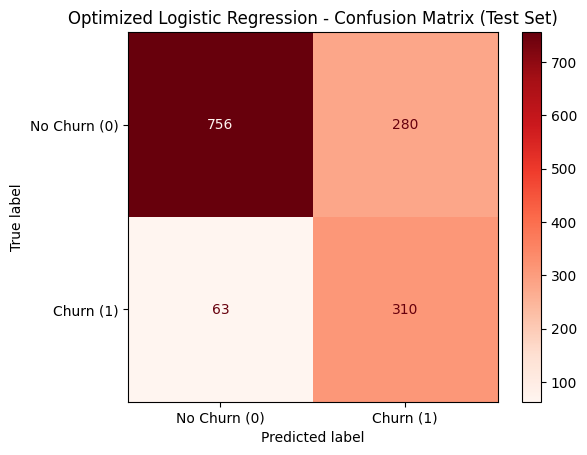


3.a: Optimized Logistic Regression - PR-AUC (Train Set): 0.4615
3.b: Optimized Logistic Regression - PR-AUC (Test Set): 0.4814


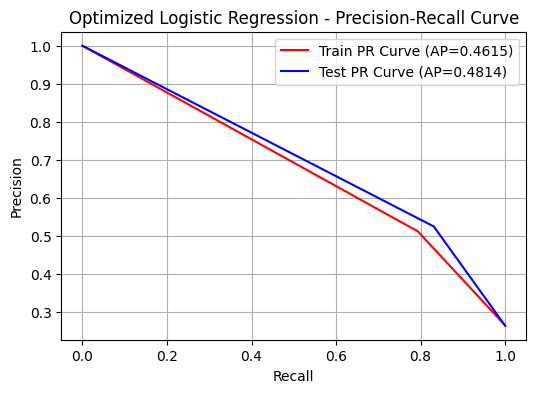

In [35]:
# Evaluate the best logistic regression model on Train and Test sets:

best_log_model_eval = evaluate_classification_model(
    best_log_model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Optimized Logistic Regression",
)

### 4.2 Decision Tree

#### a. Initial Model

In [36]:
clf_model = DecisionTreeClassifier(random_state=42)
clf_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### b. Model Evaluation


1.a: Decision Tree Classifier - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4138
           1       1.00      0.98      0.99      1496

    accuracy                           0.99      5634
   macro avg       0.99      0.99      0.99      5634
weighted avg       0.99      0.99      0.99      5634


2.a: Decision Tree Classifier - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1036
           1       0.47      0.49      0.48       373

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



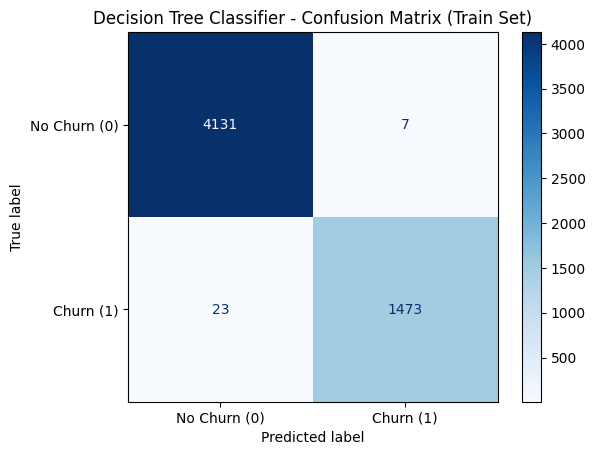

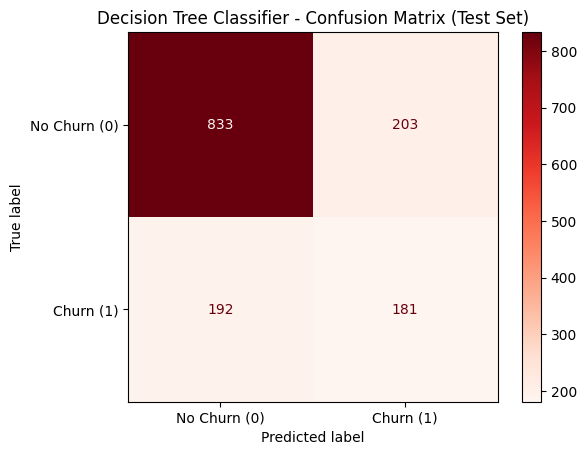


3.a: Decision Tree Classifier - PR-AUC (Train Set): 0.9841
3.b: Decision Tree Classifier - PR-AUC (Test Set): 0.3650


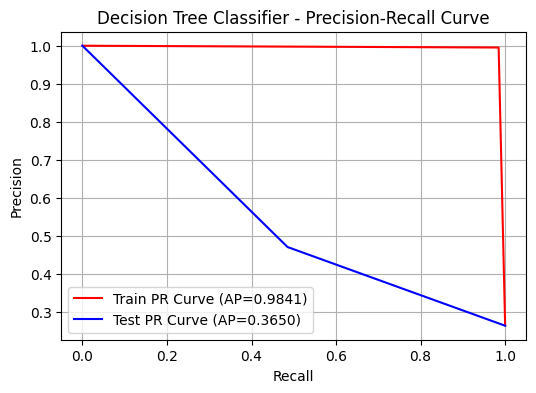

In [37]:
# Evaluate the best decision tree model on Train and Validation sets:
clf_model_eval = evaluate_classification_model(
    clf_model, X_train, y_train, X_test, y_test, model_name="Decision Tree Classifier"
)

#### c. Tunning hyperparamter

In [38]:
clf_tmp = DecisionTreeClassifier(random_state=42)
path = clf_tmp.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
alpha_scores = []

for ccp_alpha in ccp_alphas:
    fold_scores = []
    for train_idx, val_idx in kfold.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        fold_scores.append(accuracy_score(y_val, y_pred))

    alpha_scores.append(np.mean(fold_scores))

best_alpha = ccp_alphas[np.argmax(alpha_scores)]
print(f"Best ccp_alpha: {best_alpha:.5f} | CV Accuracy: {max(alpha_scores):.4f}")

Best ccp_alpha: 0.00061 | CV Accuracy: 0.7895


#### d. Refit Model with ccp_alpha

In [40]:
final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None



1.a: Decision Tree Classifier with Pruning - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4138
           1       0.67      0.61      0.64      1496

    accuracy                           0.82      5634
   macro avg       0.76      0.75      0.76      5634
weighted avg       0.81      0.82      0.81      5634


2.a: Decision Tree Classifier with Pruning - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.63      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



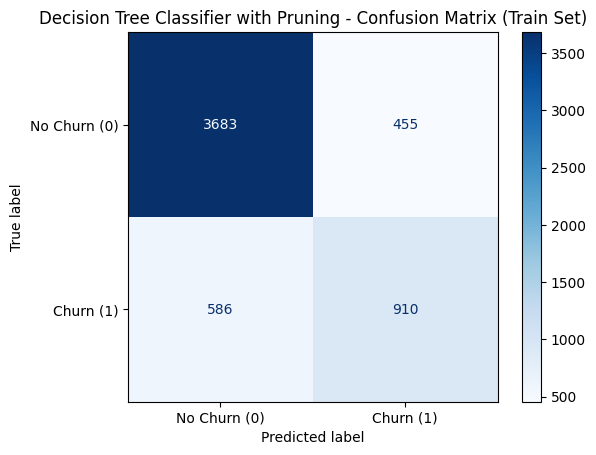

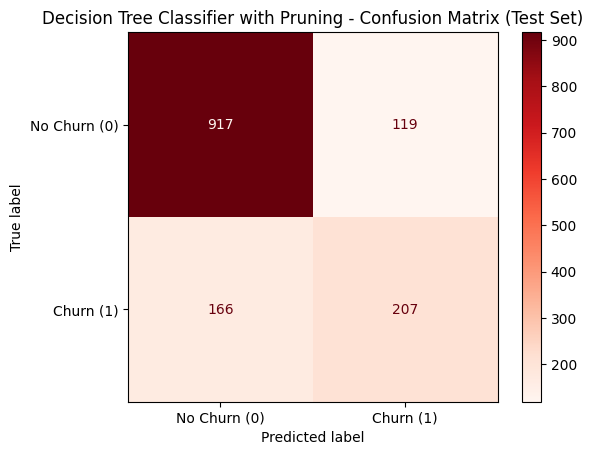


3.a: Decision Tree Classifier with Pruning - PR-AUC (Train Set): 0.5095
3.b: Decision Tree Classifier with Pruning - PR-AUC (Test Set): 0.4702


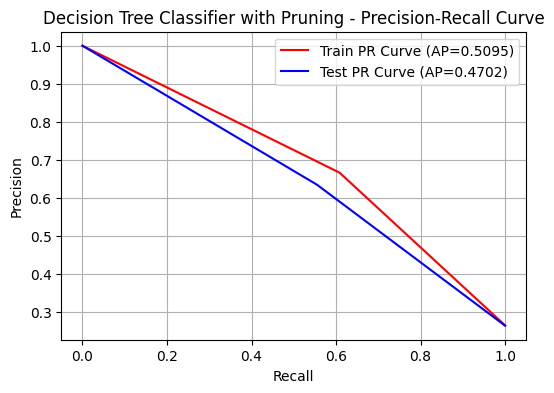

In [41]:
# Evaluate the best decision tree model on Train and test sets:

clf_model_eval = evaluate_classification_model(
    final_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Decision Tree Classifier with Pruning",
)

### 4.3 XGBoost Model

#### a. Initial Model

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

xgb_model = XGBClassifier(
    objective="binary:logistic",
    early_stopping_rounds=30,
    random_state=42,
    eval_metric="aucpr",
)
xgb_model.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True
)

[0]	validation_0-aucpr:0.67706	validation_1-aucpr:0.59751
[1]	validation_0-aucpr:0.70474	validation_1-aucpr:0.61705
[2]	validation_0-aucpr:0.71585	validation_1-aucpr:0.61931
[3]	validation_0-aucpr:0.72855	validation_1-aucpr:0.62759
[4]	validation_0-aucpr:0.73880	validation_1-aucpr:0.62729
[5]	validation_0-aucpr:0.74923	validation_1-aucpr:0.62404
[6]	validation_0-aucpr:0.75665	validation_1-aucpr:0.62577
[7]	validation_0-aucpr:0.75951	validation_1-aucpr:0.62790
[8]	validation_0-aucpr:0.76521	validation_1-aucpr:0.63097
[9]	validation_0-aucpr:0.77352	validation_1-aucpr:0.62725
[10]	validation_0-aucpr:0.77530	validation_1-aucpr:0.63059
[11]	validation_0-aucpr:0.77900	validation_1-aucpr:0.62946
[12]	validation_0-aucpr:0.78216	validation_1-aucpr:0.63229
[13]	validation_0-aucpr:0.78457	validation_1-aucpr:0.63388
[14]	validation_0-aucpr:0.78623	validation_1-aucpr:0.63255
[15]	validation_0-aucpr:0.78946	validation_1-aucpr:0.62892
[16]	validation_0-aucpr:0.79372	validation_1-aucpr:0.62730
[17]	va

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,30
,enable_categorical,False
,eval_metric,'aucpr'


#### b. Model Evaluation

In [43]:
# define a learning curves function
def learn_curves(fitted_model):

    results = fitted_model.evals_result()

    plt.plot(results["validation_0"]["aucpr"], label="Learning curve on training set")
    plt.plot(results["validation_1"]["aucpr"], label="Learning curve on test set")
    plt.xlabel("Number of boosting rounds")
    plt.ylabel("Average Precision")
    plt.title("Learning Curves")

    plt.legend()

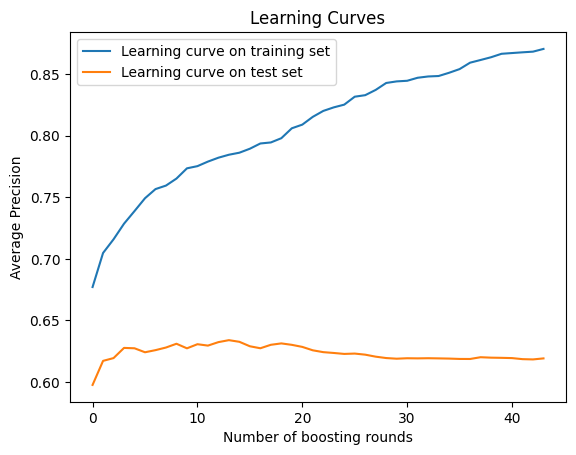

In [44]:
learn_curves(xgb_model)


1.a: XGBoost Classifier - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3316
           1       0.75      0.60      0.67      1191

    accuracy                           0.84      4507
   macro avg       0.81      0.77      0.78      4507
weighted avg       0.84      0.84      0.84      4507


2.a: XGBoost Classifier - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       822
           1       0.62      0.50      0.55       305

    accuracy                           0.78      1127
   macro avg       0.72      0.69      0.70      1127
weighted avg       0.77      0.78      0.77      1127



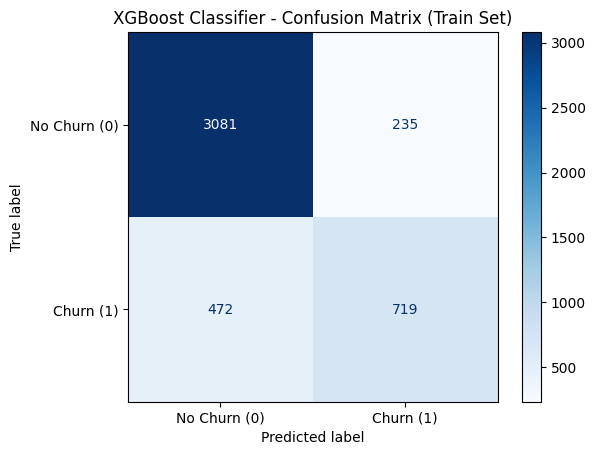

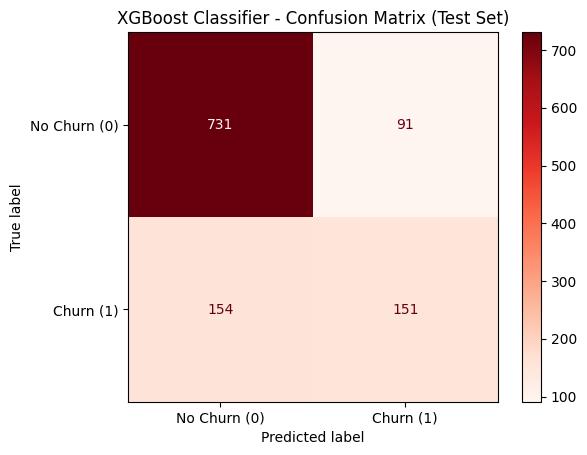


3.a: XGBoost Classifier - PR-AUC (Train Set): 0.5597
3.b: XGBoost Classifier - PR-AUC (Test Set): 0.4456


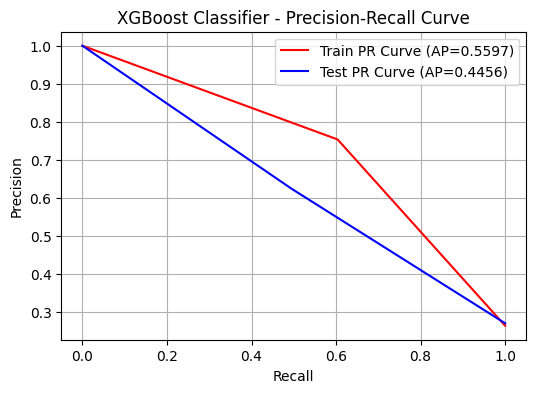

In [45]:
# Evaluate the best logistic regression model on Train and Test sets
xgb_model_eval = evaluate_classification_model(
    xgb_model, X_train, y_train, X_val, y_val, model_name="XGBoost Classifier"
)

#### c. Tunning Hyperparameter

In [46]:
# Step 1: Create parameter spaces
params = {
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 200, 400, 800, 1000],
    "scale_pos_weight": [1, 2, 3, 4],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "gamma": [0, 0.01, 0.1, 0.5, 1, 2],
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree": [0.8, 0.9, 1],
}

In [47]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [48]:
# Run RandomizedSearchCV to tune the hyperparameter
random = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    cv=kfold,
    n_iter=5,
    scoring="f1_weighted",
    n_jobs=-1,
)

random.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

print("Best hyperparameter:", random.best_params_)
print("Best score:", random.best_score_)

[0]	validation_0-aucpr:0.58440	validation_1-aucpr:0.58392
[1]	validation_0-aucpr:0.65707	validation_1-aucpr:0.61396
[2]	validation_0-aucpr:0.69040	validation_1-aucpr:0.63412
[3]	validation_0-aucpr:0.69831	validation_1-aucpr:0.63309
[4]	validation_0-aucpr:0.70553	validation_1-aucpr:0.63852
[5]	validation_0-aucpr:0.70894	validation_1-aucpr:0.63753
[6]	validation_0-aucpr:0.71220	validation_1-aucpr:0.63906
[7]	validation_0-aucpr:0.71669	validation_1-aucpr:0.64036
[8]	validation_0-aucpr:0.72042	validation_1-aucpr:0.64225
[9]	validation_0-aucpr:0.72690	validation_1-aucpr:0.64710
[10]	validation_0-aucpr:0.72885	validation_1-aucpr:0.64609
[11]	validation_0-aucpr:0.73093	validation_1-aucpr:0.64593
[12]	validation_0-aucpr:0.73225	validation_1-aucpr:0.64823
[13]	validation_0-aucpr:0.73394	validation_1-aucpr:0.64765
[14]	validation_0-aucpr:0.73658	validation_1-aucpr:0.65049
[15]	validation_0-aucpr:0.73886	validation_1-aucpr:0.65217
[16]	validation_0-aucpr:0.74051	validation_1-aucpr:0.65287
[17]	va

#### d. Refit Model with hyparameters

Best hyperparameter: {'scale_pos_weight': 2, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.01, 'colsample_bytree': 1}
Best score: 0.7558051774037462

In [49]:
xgb_model_op = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.2,
    scale_pos_weight=2,
    n_estimators=100,
    max_depth=9,
    min_child_weight=5,
    gamma=0.01,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric="aucpr",
    early_stopping_rounds=10,
    random_state=42,
)

xgb_model_op.fit(
    X_train, y_train, verbose=1, eval_set=[(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.71918	validation_1-aucpr:0.61521
[1]	validation_0-aucpr:0.73583	validation_1-aucpr:0.64801
[2]	validation_0-aucpr:0.75013	validation_1-aucpr:0.64718
[3]	validation_0-aucpr:0.76320	validation_1-aucpr:0.65714
[4]	validation_0-aucpr:0.76721	validation_1-aucpr:0.65454
[5]	validation_0-aucpr:0.77725	validation_1-aucpr:0.65953
[6]	validation_0-aucpr:0.78764	validation_1-aucpr:0.66795
[7]	validation_0-aucpr:0.79591	validation_1-aucpr:0.67445
[8]	validation_0-aucpr:0.80114	validation_1-aucpr:0.67522
[9]	validation_0-aucpr:0.80767	validation_1-aucpr:0.67566
[10]	validation_0-aucpr:0.81188	validation_1-aucpr:0.67568
[11]	validation_0-aucpr:0.81847	validation_1-aucpr:0.67771
[12]	validation_0-aucpr:0.82236	validation_1-aucpr:0.67821
[13]	validation_0-aucpr:0.82756	validation_1-aucpr:0.67823
[14]	validation_0-aucpr:0.83239	validation_1-aucpr:0.67472
[15]	validation_0-aucpr:0.83510	validation_1-aucpr:0.67295
[16]	validation_0-aucpr:0.83890	validation_1-aucpr:0.67210
[17]	va

c:\Users\v121256\allproject\customer_churn_predict\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:50:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'aucpr'


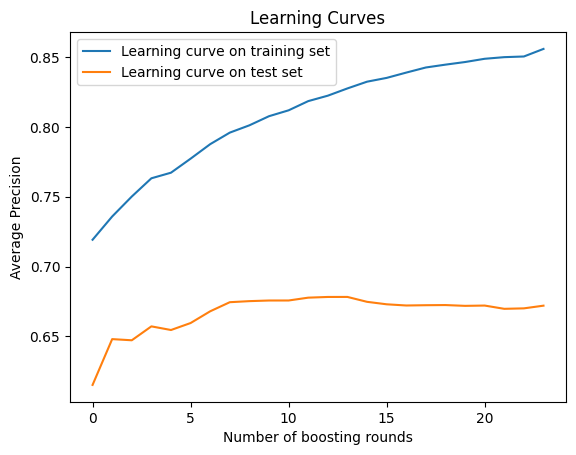

In [50]:
# Learn curves for the optimized XGBoost model
learn_curves(xgb_model_op)


1.a: Optimized XGBoost Classifier - Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3316
           1       0.69      0.84      0.76      1191

    accuracy                           0.86      4507
   macro avg       0.81      0.85      0.83      4507
weighted avg       0.87      0.86      0.86      4507


2.a: Optimized XGBoost Classifier - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1036
           1       0.56      0.70      0.62       373

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409



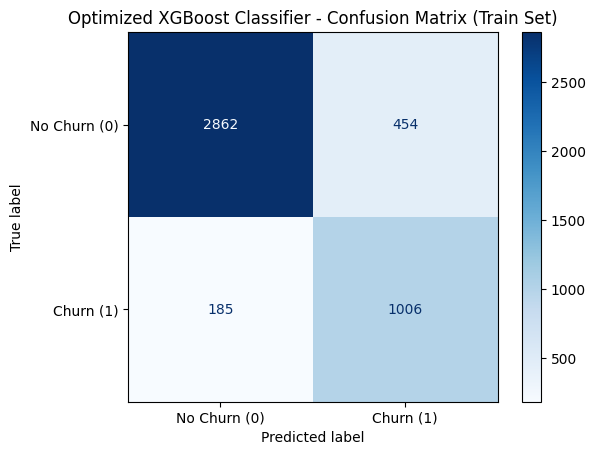

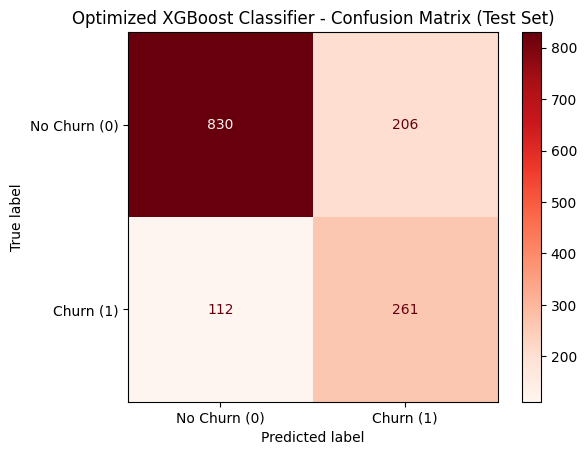


3.a: Optimized XGBoost Classifier - PR-AUC (Train Set): 0.6231
3.b: Optimized XGBoost Classifier - PR-AUC (Test Set): 0.4706


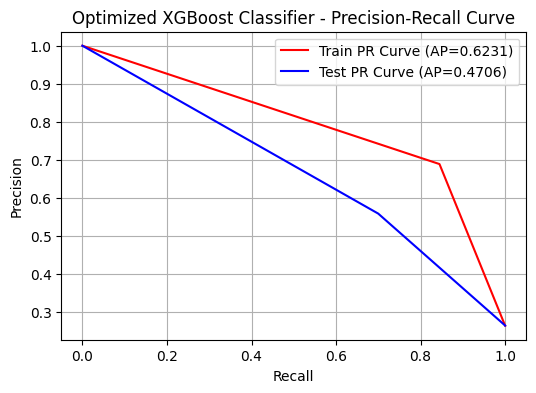

In [51]:
# Evaluate optimized XGBoost model on Train and Test sets
xgb_model_eval = evaluate_classification_model(
    xgb_model_op,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Optimized XGBoost Classifier",
)

## Section 5: Final Model and Feature Importance



In [52]:
# compute permutation importance on test set


result_test = permutation_importance(
    best_log_model,
    X_test,
    y_test,
    n_repeats=5,  
    random_state=42,
    n_jobs=2,
)
sorted_idx = result_test.importances_mean.argsort()

In [53]:
result_train = permutation_importance(
    xgb_model, X_train, y_train, n_repeats=5, random_state=42, n_jobs=2
)
sorted_idx = result_train.importances_mean.argsort()

C:\Users\v121256\AppData\Local\Temp\ipykernel_20660\772612515.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(
C:\Users\v121256\AppData\Local\Temp\ipykernel_20660\772612515.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(


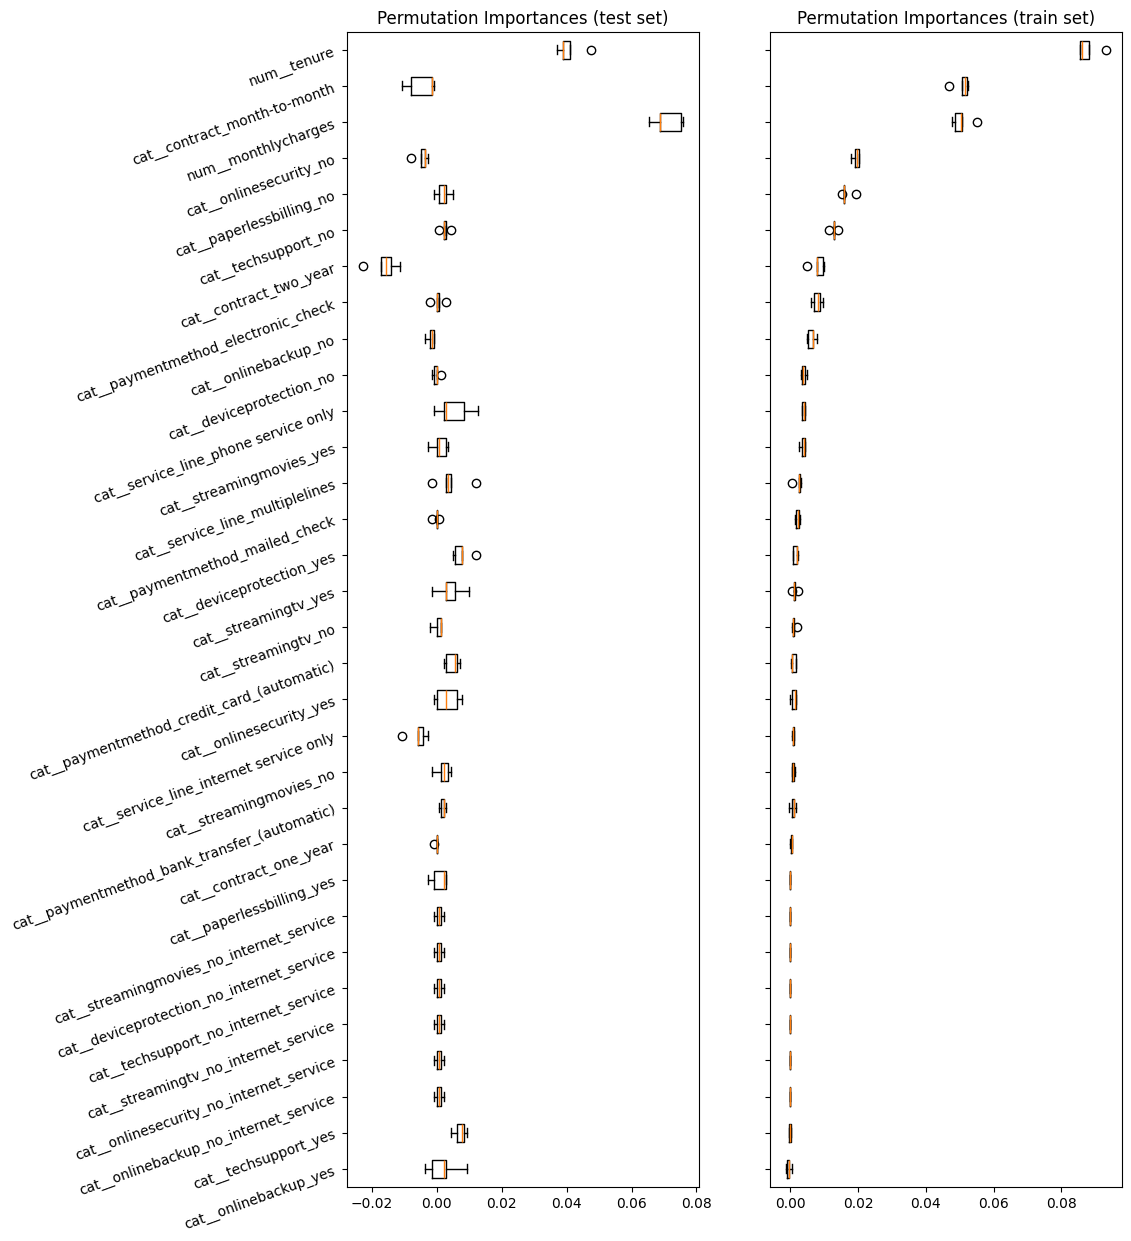

In [54]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))

# test set
ax1.boxplot(
    result_test.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax1.set_title("Permutation Importances (test set)")
ax1.set_yticklabels(feature_names[sorted_idx], rotation=20, ha="right")

# training set
ax2.boxplot(
    result_train.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax2.set_title("Permutation Importances (train set)")
ax2.set_yticklabels("")
plt.show()

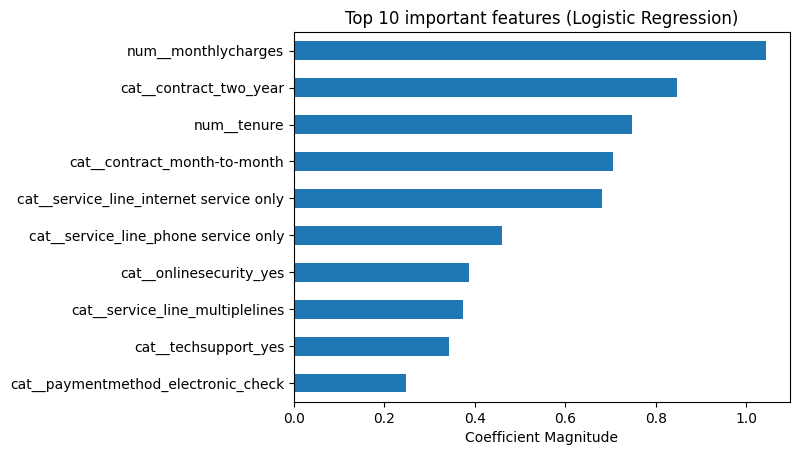

In [55]:
importance = np.abs(best_log_model.coef_[0])
feat_importances = pd.Series(importance, index=feature_names)

feat_importances.nlargest(10).plot(kind="barh")
plt.title("Top 10 important features (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.gca().invert_yaxis()

In [ ]:
#save the best model to deploy
joblib.dump(best_log_model, "logistic_model.pkl")

['logistic_model.pkl']